In [ ]:
import numpy as np
import tensorflow as tf
import os
import urllib.request
import zipfile
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
def load_X(file_path):
    return np.loadtxt(file_path, dtype=np.float32)

def load_y(file_path):
    return np.loadtxt(file_path, dtype=np.int32) - 1

dataset_folder = "UCI HAR Dataset"
X_train = load_X(f"{dataset_folder}/train/X_train.txt")
y_train = load_y(f"{dataset_folder}/train/y_train.txt")
X_test = load_X(f"{dataset_folder}/test/X_test.txt")
y_test = load_y(f"{dataset_folder}/test/y_test.txt")

timesteps = 17
features = X_train.shape[1] // timesteps
X_train = X_train.reshape(-1, timesteps, features)
X_test = X_test.reshape(-1, timesteps, features)

y_train = to_categorical(y_train, num_classes=6)
y_test = to_categorical(y_test, num_classes=6)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, shuffle=True
)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (5881, 17, 33), y_train: (5881, 6)
X_val: (1471, 17, 33), y_val: (1471, 6)
X_test: (2947, 17, 33), y_test: (2947, 6)


In [ ]:
model = Sequential([
    Conv1D(256, kernel_size=3, activation='relu', padding='same',
           kernel_regularizer=l2(1e-4), input_shape=(timesteps, features)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(512, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(512, kernel_size=5, activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    LSTM(128, return_sequences=False),

    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 17, 256)             │          25,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 17, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 8, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 8, 512)              │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 512)              │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 4, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 4, 512)              │       1,311,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 4, 512)              │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 2, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         328,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,130,566 (8.13 MB)

 Trainable params: 2,128,006 (8.12 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [ ]:
optimizer = AdamW(learning_rate=0.001, weight_decay=1e-4)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True, verbose=1)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50, batch_size=64,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint]
)

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7450 - loss: 0.7490
Epoch 1: val_loss improved from inf to 1.15314, saving model to best_model.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.7462 - loss: 0.7458 - val_accuracy: 0.6356 - val_loss: 1.1531 - learning_rate: 0.0010
Epoch 2/50
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9489 - loss: 0.2386
Epoch 2: val_loss improved from 1.15314 to 0.79468, saving model to best_model.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9489 - loss: 0.2383 - val_accuracy: 0.7933 - val_loss: 0.7947 - learning_rate: 0.0010
Epoch 3/50
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9606 - loss: 0.2060
Epoch 3: val_loss improved from 0.79468 to 0.36313, saving model to best_model.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9608 - loss: 0.2058 - val_accuracy: 0.9109 - val_loss: 0.3631 - learning_rate: 0.0010
Epoch 4/50
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9718 - loss: 0.1675
Epoch 4: val_loss improved from 0.36313 to 0.32131, saving model to best_model.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9717 - loss: 0.1676 - val_accuracy: 0.8865 - val_loss: 0.3213 - learning_rate: 0.0010
Epoch 5/50
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9758 - loss: 0.1552
Epoch 5: val_loss improved from 0.32131 to 0.30141, saving model to best_model.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9756 - loss: 0.1559 - val_accuracy: 0.9245 - val_loss: 0.3014 - learning_rate: 0.0010
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9779 - loss: 0.1521
Epoch 6: val_loss improved from 0.30141 to 0.14561, saving model to best_model.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9780 - loss: 0.1521 - val_accuracy: 0.9796 - val_loss: 0.1456 - learning_rate: 0.0010
Epoch 7/50
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9795 - loss: 0.1352
Epoch 7: val_loss did not improve from 0.14561
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9794 - loss: 0.1356 - val_accuracy: 0.9599 - val_loss: 0.2078 - learning_rate: 0.0010
Epoch 8/50
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9750 - loss: 0.1447
Epoch 8: val_loss did not improve from 0.14561
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9751 - loss: 0.1448 - val_accuracy: 0.9456 - val_loss: 0.2372 - learning_rate: 0.0010
Epoch 9/50
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9737 - loss: 0.1555
Epoch 9: val_loss did not improve from 0.14561
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9736 - loss: 0.1557 - val_accuracy: 0.8763 - val_loss: 0.4460 - learning_rate: 0.0010
Epoch 10/50
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 13

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9928 - loss: 0.0854 - val_accuracy: 0.9857 - val_loss: 0.1083 - learning_rate: 2.5000e-04
Epoch 15/50
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9932 - loss: 0.0837
Epoch 15: val_loss did not improve from 0.10829
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9933 - loss: 0.0837 - val_accuracy: 0.9742 - val_loss: 0.1319 - learning_rate: 2.5000e-04
Epoch 16/50
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9945 - loss: 0.0816
Epoch 16: val_loss improved from 0.10829 to 0.09932, saving model to best_model.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9945 - loss: 0.0815 - val_accuracy: 0.9878 - val_loss: 0.0993 - learning_rate: 2.5000e-04
Epoch 17/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9966 - loss: 0.0755
Epoch 17: val_loss did not improve from 0.09932
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9966 - loss: 0.0755 - val_accuracy: 0.9830 - val_loss: 0.1057 - learning_rate: 2.5000e-04
Epoch 18/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9950 - loss: 0.0759
Epoch 18: val_loss did not improve from 0.09932
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9950 - loss: 0.0759 - val_accuracy: 0.9816 - val_loss: 0.1031 - learning_rate: 2.5000e-04
Epoch 19/50
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9976 - loss: 0.0685
Epoch 19: val_loss did not improve from 0.09932
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9975 - loss: 0.0688 - val_accuracy: 0.9850 - val_loss: 0.1125 - learning_rate: 2.5000e-04
Epoch 20/50
89/92 ━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9955 - loss: 0.0698 - val_accuracy: 0.9884 - val_loss: 0.0992 - learning_rate: 1.2500e-04
Epoch 21/50
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9974 - loss: 0.0690
Epoch 21: val_loss did not improve from 0.09924
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9974 - loss: 0.0690 - val_accuracy: 0.9871 - val_loss: 0.1049 - learning_rate: 1.2500e-04
Epoch 22/50
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9990 - loss: 0.0622
Epoch 22: val_loss did not improve from 0.09924
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9989 - loss: 0.0622 - val_accuracy: 0.9871 - val_loss: 0.1116 - learning_rate: 1.2500e-04
Epoch 23/50
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9986 - loss: 0.0613
Epoch 23: val_loss improved from 0.09924 to 0.09294, saving model to best_model.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9986 - loss: 0.0613 - val_accuracy: 0.9912 - val_loss: 0.0929 - learning_rate: 6.2500e-05
Epoch 24/50
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9997 - loss: 0.0585
Epoch 24: val_loss did not improve from 0.09294
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9997 - loss: 0.0585 - val_accuracy: 0.9878 - val_loss: 0.1132 - learning_rate: 6.2500e-05
Epoch 25/50
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9989 - loss: 0.0593
Epoch 25: val_loss did not improve from 0.09294
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9989 - loss: 0.0592 - val_accuracy: 0.9898 - val_loss: 0.0975 - learning_rate: 6.2500e-05
Epoch 26/50
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9998 - loss: 0.0568
Epoch 26: val_loss did not improve from 0.09294
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9998 - loss: 0.0568 - val_accuracy: 0.9905 - val_loss: 0.0969 - learning_rate: 6.2500e-05
Epoch 27/50
89/92 ━━━━

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Test Accuracy: 95.32%


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


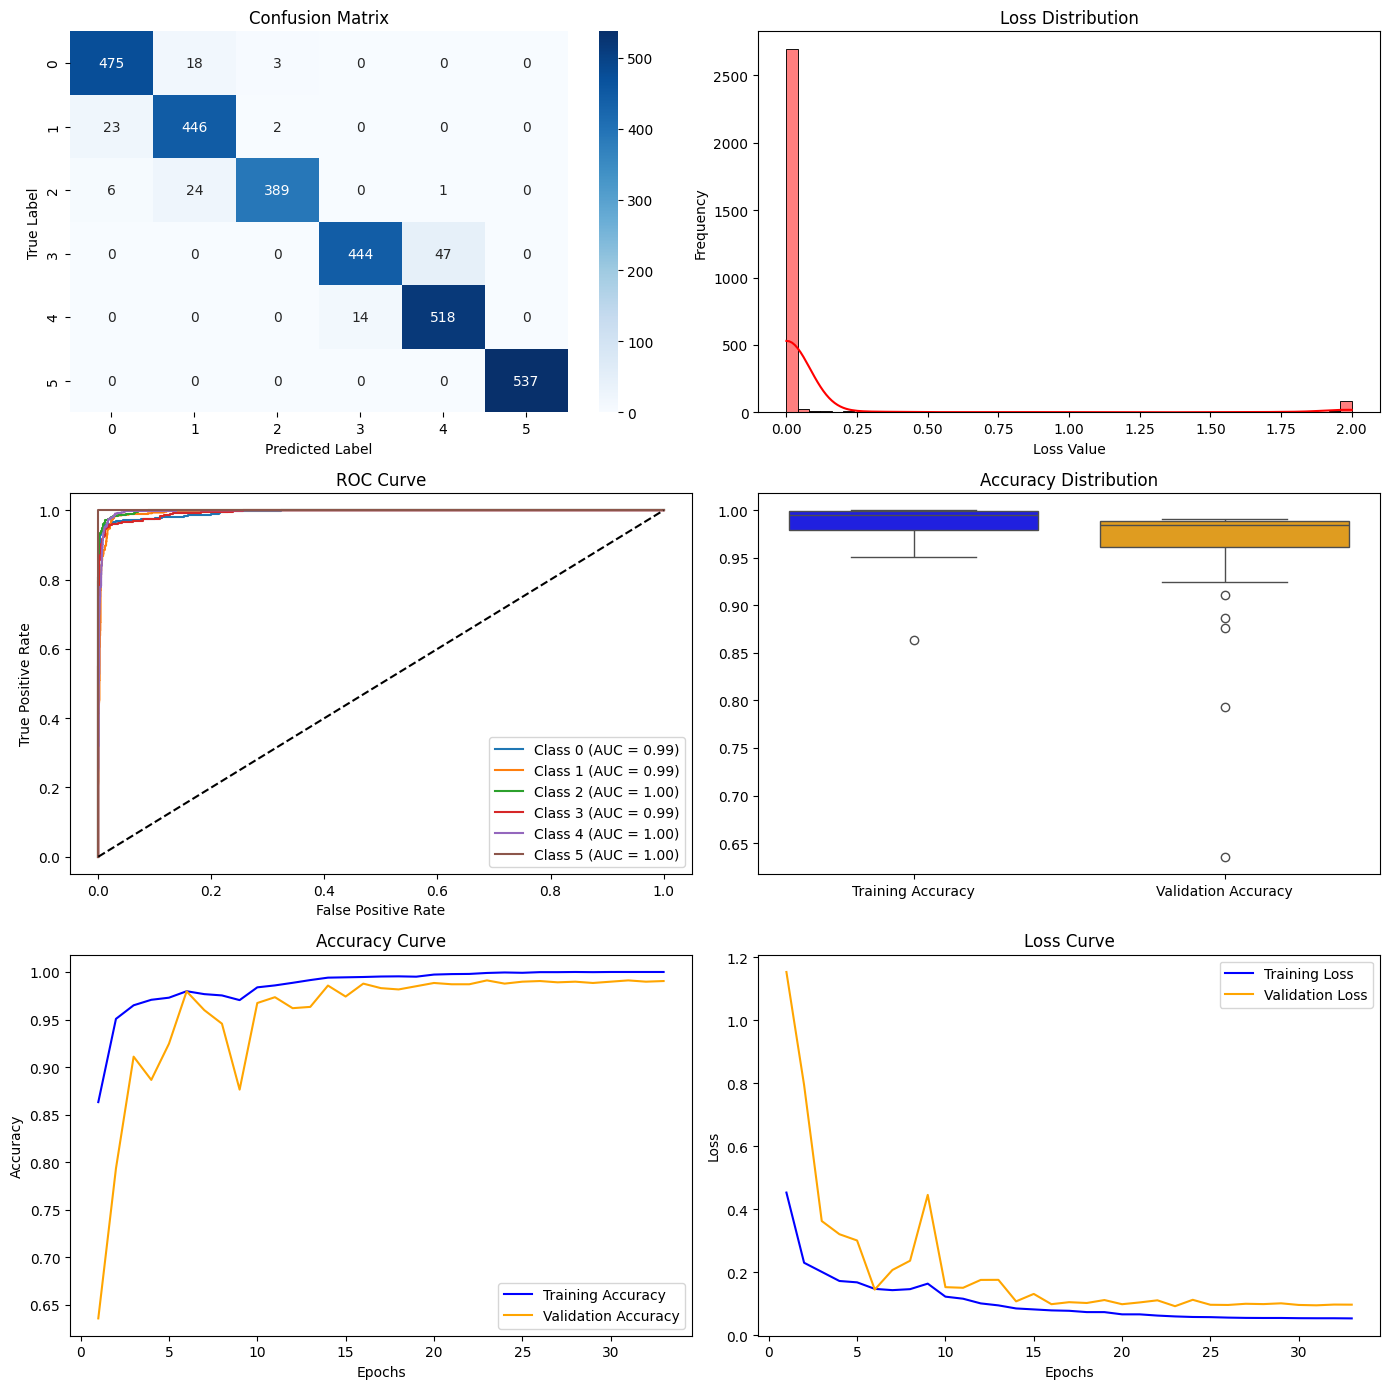

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

losses = np.abs(y_pred - y_test).sum(axis=1)

accuracies = history.history["accuracy"]
val_accuracies = history.history["val_accuracy"]
losses_train = history.history["loss"]
losses_val = history.history["val_loss"]
epochs = range(1, len(accuracies) + 1)

fig, axes = plt.subplots(3, 2, figsize=(14, 14))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(6), yticklabels=range(6), ax=axes[0, 0])
axes[0, 0].set_title("Confusion Matrix")
axes[0, 0].set_xlabel("Predicted Label")
axes[0, 0].set_ylabel("True Label")

sns.histplot(losses, bins=50, kde=True, color="red", ax=axes[0, 1])
axes[0, 1].set_title("Loss Distribution")
axes[0, 1].set_xlabel("Loss Value")
axes[0, 1].set_ylabel("Frequency")

for i in range(6):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    axes[1, 0].plot(fpr, tpr, label=f'Class {i} (AUC = {auc(fpr, tpr):.2f})')

axes[1, 0].plot([0, 1], [0, 1], 'k--')
axes[1, 0].set_title("ROC Curve")
axes[1, 0].set_xlabel("False Positive Rate")
axes[1, 0].set_ylabel("True Positive Rate")
axes[1, 0].legend()

sns.boxplot(data=[accuracies, val_accuracies], palette=["blue", "orange"], ax=axes[1, 1])
axes[1, 1].set_xticks([0, 1])
axes[1, 1].set_xticklabels(["Training Accuracy", "Validation Accuracy"])
axes[1, 1].set_title("Accuracy Distribution")

axes[2, 0].plot(epochs, accuracies, label="Training Accuracy", color="blue")
axes[2, 0].plot(epochs, val_accuracies, label="Validation Accuracy", color="orange")
axes[2, 0].set_title("Accuracy Curve")
axes[2, 0].set_xlabel("Epochs")
axes[2, 0].set_ylabel("Accuracy")
axes[2, 0].legend()

axes[2, 1].plot(epochs, losses_train, label="Training Loss", color="blue")
axes[2, 1].plot(epochs, losses_val, label="Validation Loss", color="orange")
axes[2, 1].set_title("Loss Curve")
axes[2, 1].set_xlabel("Epochs")
axes[2, 1].set_ylabel("Loss")
axes[2, 1].legend()

plt.tight_layout()
plt.show()
